## Estimating the Parameters of a GARCH Model

*In this project I will estimate the paramentes of a GJR-GARCH(1,1,1) model with a constant mean. The volatility dynamics in a GRJ-GARCH model are given by*

## $$σ_{t}^2=ω+\sum_{i=1}^pα_iε_{t-i}^2+\sum_{j=1}^oγ_jε_{t-j}^2I_{t-j}+\sum_{k=1}^qβσ_{t-k}^2$$

### GJR-GARCH(1,1,1)

## $$σ_{t}^2=ω+(α+γI_{t-1})ε_{t-1}^2+βσ_{t-1}^2$$

Paremeters

To estimate the parameters, it is necessary to:
1. Produce some starting values
2. Estimate the parameters using (quasi-) maximum likelihood (QML)
3. Compute standard errors using a “sandwich” covariance estimator

## Import required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from numpy import size, log, pi, sum, diff, array, zeros, diag, mat, asarray, sqrt, copy
from numpy.linalg import inv
from scipy.optimize import fmin_slsqp
%matplotlib inline

The conditional log-likelihood of a normal random variable is

## $$\ln f(r_t|\mu,\sigma_t^2) = -\frac{1}{2}\bigg(\ln 2\pi+\ln\sigma_t^2+\frac{(r_t-\mu)^2}{\sigma_t^2}\bigg)$$

In [2]:

def gjr_garch_likelihood(parameters, data, sigma2, out=None):

    mu = parameters[0]
    omega = parameters[1]
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]
    
    T = size(data,0)
    eps = data - mu
    
    # Data and sigma2 are T by 1 vectors
    for t in range(1,T):
        sigma2[t] = (omega + alpha * eps[t-1]**2 + gamma * eps[t-1]**2 * (eps[t-1]<0) + beta * sigma2[t-1])
    logliks = 0.5*(log(2*pi) + log(sigma2) + eps**2/sigma2)
    loglik = sum(logliks)
    
    if out is None:
        return loglik
    else:
        return loglik, logliks, copy(sigma2)


The optimization is constrained so that $\alpha + \gamma/2 + \beta ≤ 1$, and the constraint is provided in a separate
function

In [3]:
def gjr_constraint(parameters, data, sigma2, out=None):
    alpha = parameters[2]
    gamma = parameters[3]
    beta = parameters[4]
    
    return array([1-alpha-gamma/2-beta])

The asymptotic variance is estimated using the “sandwich” form which is commonly expressed as

## $$\mathscr J^{-1}\mathscr I\mathscr J^{-1}$$ 


where $\mathscr J$ is the expected Hessian and $\mathscr I$ is the covariance of the scores. Both are numerically approximated, and the strategy for computing the Hessian is to use the definition that

## $$\mathscr J_{ij} ≈ \frac{f(\theta+e_ih_i+e_jh_j)-f(\theta+e_ih_i)-f(\theta+e_jh_j)+f(\theta)}{h_ih_j}$$ 

In [4]:
def hessian_2sided(fun, theta, args):
    f = fun(theta, *args)
    h = 1e-5*np.abs(theta)
    thetah = theta + h
    h = thetah - theta
    K = size(theta,0)
    h = np.diag(h)
    
    
    fp = zeros(K)
    fm = zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
    
    
    fpp = zeros((K,K))
    fmm = zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j], *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j], *args)
            fmm[j,i] = fmm[i,j]

    hh = (diag(h))
    hh = hh.reshape((K,1))
    hh = hh @ hh.T
    H = zeros((K,K))
    
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    return H

## Import S&P500 Data

In [5]:
#Import data
SPX = pd.read_csv('S&P.csv')
#Set index
SPX.index = SPX.pop('Date')
# Flip upside down
SPX = SPX.iloc[::-1]
# Compute returns
SPXprice = SPX['Adj Close']
SPXreturn = 100 * SPXprice.pct_change().dropna()
SPX.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-23,2909.989990,2936.310059,2908.530029,2933.679932,2933.679932,3635030000
2019-04-22,2898.780029,2909.510010,2896.350098,2907.969971,2907.969971,2997950000
2019-04-18,2904.810059,2908.399902,2891.899902,2905.030029,2905.030029,3506850000
2019-04-17,2916.040039,2918.000000,2895.449951,2900.449951,2900.449951,3602300000
2019-04-16,2912.260010,2916.060059,2900.709961,2907.060059,2907.060059,3402210000


In [6]:
# Starting values
startingVals = array([SPXreturn.mean(), SPXreturn.var() * .01, .03, .09, .90])

In [7]:
# Estimate parameters
finfo = np.finfo(np.float64)
bounds = [(10*SPXreturn.mean(), -10*SPXreturn.mean()),(finfo.eps, 2*SPXreturn.var() ),(0.0,1.0), (0.0,1.0), (0.0,1.0)]

T = SPXreturn.shape[0]
sigma2 = np.ones(T) * SPXreturn.var()

# Pass a NumPy array, not a pandas Series
args = (np.asarray(SPXreturn), sigma2)
estimates = fmin_slsqp(gjr_garch_likelihood, startingVals, \
f_ieqcons=gjr_constraint, bounds = bounds, \
args = args)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4461.975677429486
            Iterations: 14
            Function evaluations: 106
            Gradient evaluations: 13


In [8]:
loglik, logliks, sigma2final = gjr_garch_likelihood(estimates, SPXreturn, sigma2, out=True)

Computing the numerical scores and the covariance of the scores

In [9]:
step = 1e-5 * estimates
scores = zeros((T,5))
for i in range(5):
    h = step[i]
    delta = np.zeros(5)
    delta[i] = h
    loglik, logliksplus, sigma2 = gjr_garch_likelihood(estimates + delta, \
    np.asarray(SPXreturn), sigma2, out=True)
    loglik, logliksminus, sigma2 = gjr_garch_likelihood(estimates - delta, \
    np.asarray(SPXreturn), sigma2, out=True)
    scores[:,i] = (logliksplus - logliksminus)/(2*h)
I = (scores.T @ scores)/T

C:\Anaconda3\envs\TFMagic\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


The function *hessian_2sided* estimates the Hessian, and then computes the asymptotic covariance.

In [10]:
J = hessian_2sided(gjr_garch_likelihood, estimates, args)
J = J/T
Jinv = mat(inv(J))
vcv = Jinv*mat(I)*Jinv/T
vcv = asarray(vcv)

C:\Anaconda3\envs\TFMagic\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


Printing out the results

In [11]:
output = np.vstack((estimates,sqrt(diag(vcv)),estimates/sqrt(diag(vcv)))).T
print('Parameter  Estimate   Std.Err. T-stat')
param = ['mu','omega','alpha','gamma','beta']
for i in range(len(param)):
    print('{0:<11} {1:>0.6f}  {2:0.6f}    {3: 0.5f}'.format(param[i],
        output[i,0], output[i,1], output[i,2]))

Parameter  Estimate   Std.Err. T-stat
mu          -0.091860  nan     nan
omega       0.008610  nan     nan
alpha       0.000000  nan     nan
gamma       0.190990  nan     nan
beta        0.904505  nan     nan


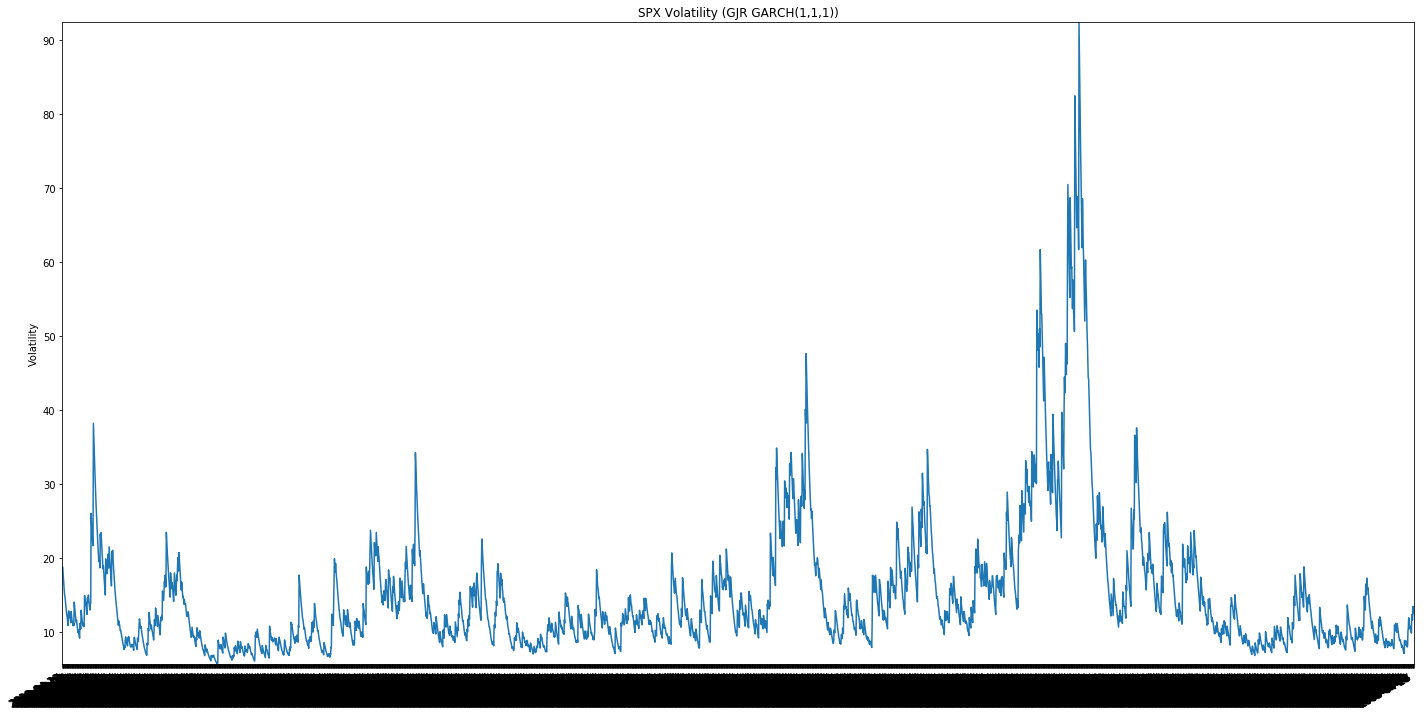

In [12]:
# Produce a plot
dates = SPX.index[1:]
fig, ax = plt.subplots(figsize=(20, 10))
volatility = pd.DataFrame(np.sqrt(252 * sigma2), index=dates)
ax.plot(volatility.index,volatility)
ax.autoscale(tight='x')
fig.autofmt_xdate()
fig.tight_layout(pad=1.5)
ax.set_ylabel('Volatility')
ax.set_title('SPX Volatility (GJR GARCH(1,1,1))')
plt.show()